# Homework 5

In this homework, we will implement U-Net to perform instance segmentation on mock data. 
Instance segmentation is the task of detecting and delineating each distinct object of interest appearing in an image. It plays a significant role in biomedical morphological analysis (ie. Brain Tumor Diagnosis).
U-Net was proposed by Ronneberger in 2015 and has since become one of the most popular ML architecture for Biomedical Instance Segmentation.
You can find more information on U-Net and its application in this week's lecture. You can also check out the original [research paper](https://arxiv.org/abs/1505.04597).

As usual, sections where you have to write code are denoted by a "#CODE HERE". 


## 0. Helper Functions

Before we begin, here's the brief overview of other python files in the google drive folder alongside this colab notebook. We will be using these functions quite a bit in the assignment. Even though all the code needed to use these functions will be provided to you, we still encourage you to skim through them for your own understanding.

_utils.py : Plotting functions for visualization_

_loss.py : DICE loss function_

_simulation.py : Functions to generate mock data_

## 1. Import Libraries & Set up

As usual, we will import the necessary libraries. Remember to pip install any libraries you do not have. 

In [ ]:
#Computational Libraries
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.nn as nn
import math
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import torchvision
from collections import defaultdict
import torch.nn.functional as F


#Visualization Libraries
import matplotlib.pyplot as plt

#Utils Libraries
import sys
import time

First, we will mount our google drive. This will allow us to access the helper functions mentioned in the previous section. 

In [ ]:
# Google Drive Connection
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will add this assignment's folder to the system path. This will allow us to import the helper modules in the next code block. If you added the class's google drive folder into your drive, the system path to be appended should be
`/content/drive/My Drive/ML in Healthcare Class Folder/Assignments/Homework 5`


  

In [ ]:
sys.path.append("/content/drive/My Drive/ML in Healthcare Class Folder/Assignments/Homework 5")

Now we will import the helper modules.

In [ ]:
import simulation
import utils
from loss import dice_loss

Next, we will enable GPU from Notebook settings for faster training
- In settings, select Edit > Notebook Settings
- Select GPU from Hardware Accelerator dropdown list

In [ ]:
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla T4


## 2. Data Visualization

Let's first take a look out the type of images we are attempting to segment. We will first generate some random images. 

In [ ]:
# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=2)

print("input_images shape and range", input_images.shape, input_images.min(), input_images.max())
print("target_masks shape and range", target_masks.shape, target_masks.min(), target_masks.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]

input_images shape and range (2, 192, 192, 3) 0 255
target_masks shape and range (2, 6, 192, 192) 0.0 1.0


Next, we will plot the input image and its target mask. Our goal is to build a U-Net model that is capable of performing instance segmentation on the input image to produce the target mask.

Left: Input image (black and white), Right: Target mask (6ch)

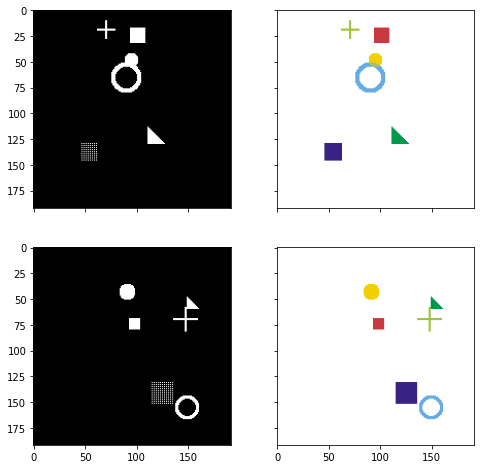

In [ ]:
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

## 3. Data Preparation
### 3.1 Prepare Dataset and DataLoader

In this section, we define a map-style dataset and DataLoader for easy data loading. Check out [this link](https://pytorch.org/docs/stable/data.html) for more information on pytorch's data loading utility.


In [ ]:
class SimDataset(Dataset):
  def __init__(self, count, transform=None):
    self.input_images, self.target_masks = simulation.generate_random_data(192, 192, count=count)
    self.transform = transform

  def __len__(self):
    return len(self.input_images)

  def __getitem__(self, idx):
    image = self.input_images[idx]
    mask = self.target_masks[idx]
    if self.transform:
      image = self.transform(image)

    return [image, mask]

# use the same transformations for train/val in this example
trans = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

#Create training set and validation set 
train_set = SimDataset(2000, transform = trans)
val_set = SimDataset(200, transform = trans)

#Prepare image datasets with training set and validation set
image_datasets = {
  'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
  'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
  'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

### 3.1 Check outputs from DataLoader

torch.Size([25, 3, 192, 192]) torch.Size([25, 6, 192, 192])


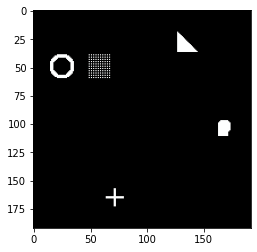

In [ ]:
def reverse_transform(inp):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  inp = (inp * 255).astype(np.uint8)

  return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)

plt.imshow(reverse_transform(inputs[3]))

## 3. Model Building
Now let's build our model!! 

Here's a diagram of the U-Net's architecture you will be implementing.


![alt](https://github.com/athenaleong/Medecal_Misc/blob/main/Unet.png?raw=true)

Below is a breakdown of the architecture by layers and the functions for implementation. 

For downsampling path:

Each layer consists of 
*   [2d Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with kernel size of 3 and padding of 1 
*   [ReLu Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)  
*   [2d Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with kernel size of 3 and padding of 1 
*   [ReLu Activation Function ](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 
* [Max Pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) with kernel size of 2

For upsampling path:

Each layer consists of
*   [Concatation](https://pytorch.org/docs/stable/generated/torch.cat.html) with matrix from corresponding downsampling path
*   [2d Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with kernel size of 3 and padding of 1 
*   [ReLu Activation Function](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)  
*   [2d Convolution](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with kernel size of 3 and padding of 1 
*   [ReLu Activation Function ](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 
* [Upsampling](https://pytorch.org/docs/stable/generated/torch.nn.Upsample.html) with scale factor of 2 and aligned corners in bilinear mode 

Since both upsampling path and downsamping use double convolutions. It is good practice to write a helper function.

In addition, we will be using [Adam optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) with an initial learning rate of 1e-4. To update the learning rate, we will be using the [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR) 






In [ ]:
def double_conv(in_channels, out_channels):
  """ 
    Helper funciton to perform 2x (Conv2d + Relu) 
    in_channels: Number of input channels
    out_channels: Number of output channels after 2 convolution
  """
  #CODE_HERE
  return torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, out_channels, 3, padding=1),
      torch.nn.ReLU(inplace=True),
      torch.nn.Conv2d(out_channels, out_channels, 3, padding=1),
      torch.nn.ReLU(inplace=True)
  )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
                
        #CODE_HERE
        self.first_dconv = double_conv(3, 64)
        self.second_dconv = double_conv(64, 128)
        self.third_dconv = double_conv(128, 256)
        self.last_dconv = double_conv(256, 512)

        self.first_upconv = double_conv(256 + 512, 256)
        self.second_upconv = double_conv(128 + 256, 128)
        self.third_upconv = double_conv(128 + 64, 64)  

        self.last_conv = nn.Conv2d(64, n_class, 1)
        
    def forward(self, x):
        #CODE_HERE
        maxpooling = torch.nn.MaxPool2d(2)
        
        conv1 = self.first_dconv(x)
        dconv1 = maxpooling(conv1)
        
        conv2 = self.second_dconv(dconv1)
        dconv2 = maxpooling(conv2)

        conv3 = self.third_dconv(dconv2)
        dconv3 = maxpooling(conv3)

        conv4 = self.last_dconv(dconv3)
        
        upsampling = torch.nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        upsample = upsampling(conv4)        
        concat = torch.cat([upsample, conv3], dim=1)
        uconv1 = self.first_upconv(concat)
        
        upsample = upsampling(uconv1)        
        concat = torch.cat([upsample, conv2], dim=1)
        uconv2 = self.second_upconv(concat)
        
        upsample = upsampling(uconv2)       
        concat = torch.cat([upsample, conv1], dim=1)
        uconv3 = self.third_upconv(concat)
        
        out = self.last_conv(uconv3)
        
        return out

## 4. Model Training 
### 4. 1 Instantiate Model
Now that we have built our model, let's train it. 
We will 
- Instantiate Model
- Move the model to GPU if available
- Show Model summaries

In [ ]:
#Move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

#Instantiate model with 6 classes
model = UNet(6) #CODE_HERE
model = model.to(device)

device cuda


In [ ]:
#Visualize Model Summary
model

UNet(
  (first_dconv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (second_dconv): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (third_dconv): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (last_dconv): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (first_upconv): Sequential

In [ ]:
checkpoint_path = "checkpoint.pth"

def calc_loss(pred, target, metrics, bce_weight=0.5):
    """ Function to calculate loss """
    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss
def print_metrics(metrics, epoch_samples, phase): 
    """  Print Metrics during training """  
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            if phase == 'train':
              scheduler.step()
              for param_group in optimizer.param_groups:
                  print("LR", param_group['lr'])

            # save the model weights
            if phase == 'val' and epoch_loss < best_loss:
                print(f"saving best model to {checkpoint_path}")
                best_loss = epoch_loss
                torch.save(model.state_dict(), checkpoint_path)

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(torch.load(checkpoint_path))
    return model

In [ ]:
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train: bce: 0.145584, dice: 0.949698, loss: 0.547641
LR 0.0001
val: bce: 0.016655, dice: 0.770899, loss: 0.393777
saving best model to checkpoint.pth
0m 57s
Epoch 1/9
----------
train: bce: 0.016491, dice: 0.550163, loss: 0.283327
LR 0.0001
val: bce: 0.016174, dice: 0.370150, loss: 0.193162
saving best model to checkpoint.pth
0m 57s
Epoch 2/9
----------
train: bce: 0.013217, dice: 0.302633, loss: 0.157925
LR 0.0001
val: bce: 0.010964, dice: 0.199654, loss: 0.105309
saving best model to checkpoint.pth
0m 57s
Epoch 3/9
----------
train: bce: 0.010513, dice: 0.184996, loss: 0.097755
LR 0.0001
val: bce: 0.007880, dice: 0.165944, loss: 0.086912
saving best model to checkpoint.pth
0m 57s
Epoch 4/9
----------
train: bce: 0.006355, dice: 0.128786, loss: 0.067570
LR 0.0001
val: bce: 0.003449, dice: 0.062818, loss: 0.033134
saving best model to checkpoint.pth
0m 57s
Epoch 5/9
----------
train: bce: 0.003896, dice: 0.065480, loss: 0.034688
LR 0.0001
val: bce: 0.002994, dice: 

## 5. Model Evaluation

Awesome! We have finished training our model. We can now evaluate its performance on our training dataset

inputs.shape torch.Size([3, 3, 192, 192])
labels.shape torch.Size([3, 6, 192, 192])
pred.shape (3, 6, 192, 192)


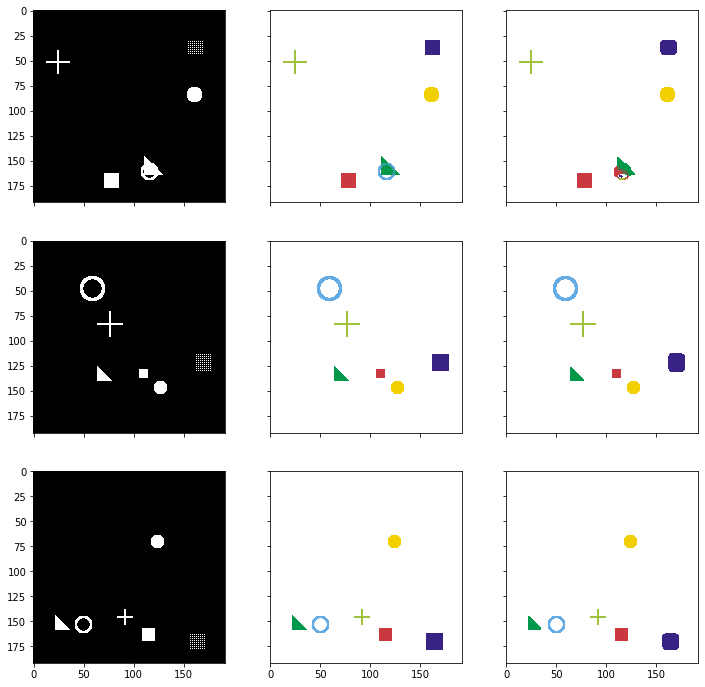

In [ ]:
model.eval()   # Set model to the evaluation mode

# Create a new simulation dataset for testing
test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)

# Get the first batch
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)
print('inputs.shape', inputs.shape)
print('labels.shape', labels.shape)

# Predict
pred = model(inputs)
# The loss functions include the sigmoid function.
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print('pred.shape', pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])


## 6. Homework Submission

🎉 Congrats, you have built your first U-Net model. Please download a PDF of your filled in Google Colab Notebook with all outputs and filled in code visible and upload it [here](https://forms.gle/1rwdk9CpjH3fRQ8NA).